# Multi-Asset TOB Example

In this example we showcase a simple pairs trading strategy on one exchange. 

The strategy is based on the co-movement of two assets, UNI & SUSHI, and is heavily inspired by [this](https://github.com/jamesmawm/High-Frequency-Trading-Model-with-IB/blob/master/models/hft_model_1.py) model from James Ma. 

For it, we need two measures: 
- beta: $\beta = \frac{\mu_{SUSHI}}{\mu_{UNI}}$ where $\mu$ is the rolling average of the mid-price of an asset. The calculation used here is the one-pass EMA with a decay of 100. This beta between the two means is used to infer the mid-price of the SUSHI based on UNI. So $\overline{\text{SUSHI}} = \text{UNI} \times \beta$ where we have a trading decision.
- vol_ratio: $\gamma = \frac{\sigma_{SUSHI}}{\sigma_{UNI}}$

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# Import package
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from src.exchange import TOB_Exchange
from src.utils.one_pass_calculations import mean, var

%load_ext autoreload 
%autoreload 2

## Import data

In [2]:
folder_path = 'data_loader/datasets/'

In [3]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)
    return df

In [24]:
symbols = ['SUSHIUSDT', 'UNIUSDT']

trades_list = []
quotes_list = []

for symbol in symbols: 
    # define folder path
    quotes_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'quotes']
    
    trades_list += [
        f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
        and f.split('_')[0] == 'binance-futures' 
        and f.split('_')[-1] == symbol + '.csv.gz'
        and f.split('_')[1] == 'trades']

In [25]:
quotes = get_data(quotes_list)
trades = get_data(trades_list)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.66it/s]


## Prepare Exchange

In [43]:
binance = TOB_Exchange(exchange_type = 'future')

In [49]:
usd_amount = 10_000
prices = quotes.groupby('symbol').ask_price.max()

per_asset = usd_amount // prices

In [50]:
for symbol in symbols: 
    binance.add_market(symbol, symbol[:-4], symbol[-4:])
    # binance.add_balance(symbol[:-4], per_asset[symbol])
    binance.add_balance(symbol[-4:], usd_amount)
    binance.load_tob(quotes.loc[quotes.symbol == symbol, ['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy(), symbol)
    binance.load_trades(trades.loc[trades.symbol == symbol, ['timestamp', 'id', 'side', 'price', 'amount']].to_numpy(), symbol)

2023-07-29 14:46:46,128 - INFO - src.exchange - Loading 284292 TOB-Updates for SUSHIUSDT
2023-07-29 14:46:47,191 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 14:46:47,230 - INFO - src.exchange - Loading 179322 trades for SUSHIUSDT
2023-07-29 14:46:47,523 - INFO - src.exchange - Trades loaded successfully
2023-07-29 14:46:47,571 - INFO - src.exchange - Loading 362406 TOB-Updates for UNIUSDT
2023-07-29 14:46:49,220 - INFO - src.exchange - TOB-Updates loaded successfully
2023-07-29 14:46:49,284 - INFO - src.exchange - Loading 297836 trades for UNIUSDT
2023-07-29 14:46:49,832 - INFO - src.exchange - Trades loaded successfully


## Spot Example

In [9]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.under = 1 if impl_mid < self.information[self.symbols[0]]['price'] else 0
        return [vol_ratio, beta, impl_mid, self.trend, self.under]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.under and self.trend and self.position <= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position += 1
        
        elif not self.under and not self.trend and self.position >= 0: 
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position -= 1



    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [10]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)

In [11]:
strat.run_simulation()

2023-07-29 13:29:50,114 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477158, order_id=1, side=0, taker=True, amount=189.12529550827423, price=5.287, fees=0.19998108747044918, entryTime=1688170077624000.0, eventTime=1688170077627907.0)
2023-07-29 13:29:50,115 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477159, order_id=0, side=1, taker=True, amount=1447.7017734346725, price=0.6908, fees=0.20001447701773434, entryTime=1688170077624000.0, eventTime=1688170077629493.5)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=477160, order_id=3, side=1, taker=True, amount=188.3771310162946, price=5.309, fees=0.20001883771310164, entryTime=1688171883825000.0, eventTime=1688171883829124.0)
2023-07-29 13:29:50,359 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=477161, order_id=2, side=0, taker=True, amount=1452.3273545857237, price=0.6885, fees=0.19998547672645417, entryTi

In [13]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'asset_a', 'quote', 'asset_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind['asset_a'] * ind['price_a']
ind['usd_b'] = ind['asset_b'] * ind['price_b']
ind['combined'] = ind.usd_a + ind.quote + ind.usd_b
ind['log_bal'] = np.log(ind.combined / ind.combined.shift())

In [55]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

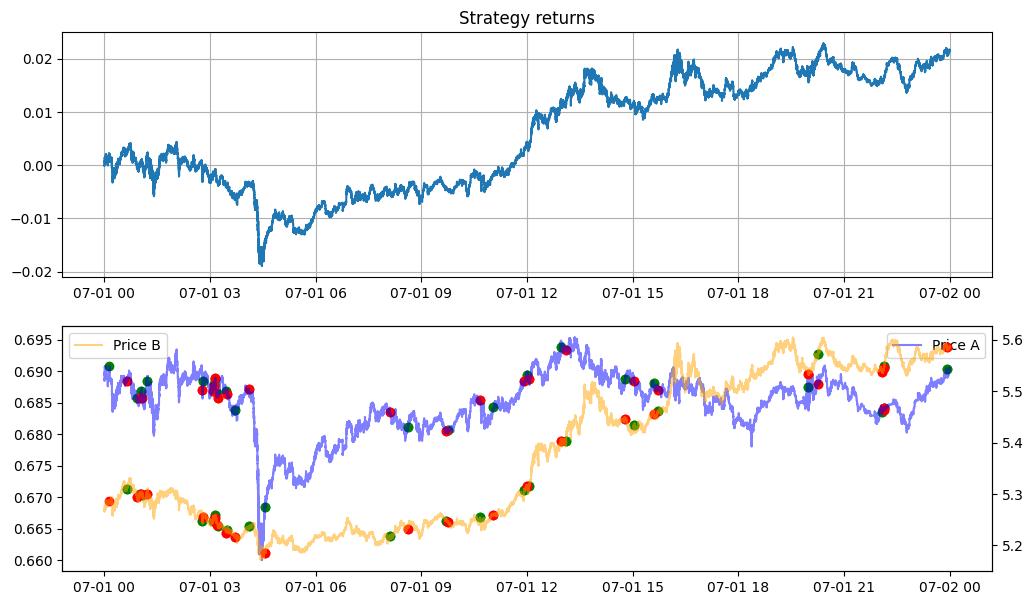

In [70]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.log_bal.cumsum(), label='change_midprice')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()

## Futures Example

Here we make an example with only having USDT in our account and trading on a futures exchange. This means that were handling positions and only adjust the balances in USD.

The strategy itself is the same with a small adjustment where we expect a minimum distance in percent that the implied midprice must be off. 

In [48]:
class strategy:
    def __init__(self, exchange, symbols, lookback_mean, lookback_var) -> None:

        # Amonut of USDT that will be traded
        self.threshold = 0.004
        self.volume = 1_000

        self.information = {}
        self.symbols = symbols
        self.exchange = exchange

        self.warmup = 5_000

        self.opened = False

        self.indicators = []

        for symbol in symbols: 
            self.information[symbol] = {}
            self.information[symbol]['ema'] = mean(lookback_mean)
            self.information[symbol]['var'] = var(lookback_var, calculate_ema=True)
            self.information[symbol]['price'] = None

        self.position = 0
            
    def trading_indicators(self):
        if self.information[self.symbols[1]]['var'].var == 0:
            vol_ratio = 0
        else:
            vol_ratio = self.information[self.symbols[0]]['var'].var / self.information[self.symbols[1]]['var'].var
        self.trend = 1 if vol_ratio > 1 else 0
        beta = self.information[self.symbols[0]]['ema'].ema / self.information[self.symbols[1]]['ema'].ema
        impl_mid = self.information[self.symbols[1]]['price'] * beta
        self.ema_diff = impl_mid / self.information[self.symbols[0]]['price'] - 1
        return [vol_ratio, beta, impl_mid, self.trend, self.ema_diff]

    def update_values(self, symbol: str, new_value: float, ts: float) -> list:
        change = new_value / self.information[symbol]['price'] - 1 if self.information[symbol]['price'] is not None else 0
        ema = self.information[symbol]['ema'].update(new_value, ts)
        var = self.information[symbol]['var'].update(change, ts)
        self.information[symbol]['price'] = new_value
        # self.indicators.append([ts, symbol, new_value, ema, var])
        return [new_value, ema, var]

    def decision(self, ts):
        if self.ema_diff < -self.threshold and self.trend and self.position == 0: 
            print('enter long')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 1, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 0, ts)
            self.position = 1

        elif self.trend and self.position == -1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close short')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 1, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 0, ts)
            self.position = 0
        
        elif self.ema_diff > self.threshold and not self.trend and self.position == 0: 
            print('enter short')
            self.exchange.market_order(self.symbols[0], self.volume / self.information[self.symbols[0]]['price'], 0, ts)
            self.exchange.market_order(self.symbols[1], self.volume / self.information[self.symbols[1]]['price'], 1, ts)
            self.position = -1

        elif not self.trend and self.position == 1 and abs(binance.positions[self.symbols[0]]) > 1: 
            print('close long')
            self.exchange.market_order(self.symbols[0], binance.positions[self.symbols[0]], 0, ts)
            self.exchange.market_order(self.symbols[1], binance.positions[self.symbols[1]], 1, ts)
            self.position = 0

    def run_simulation(self):

        while len(self.exchange.events) > 0:
            self.exchange._simulation_step()

            ts = self.exchange.last_timestamp

            out = [ts]

            for symbol in self.symbols: 
                value = self.exchange.fetch_tob(symbol)
                mid = (value['ask_price'] + value['bid_price']) / 2
                out += self.update_values(symbol, mid, ts)
            
            out += self.trading_indicators()
            out += self.exchange.balances.values()
            out += self.exchange.positions.values()

            self.indicators.append(out)
            if self.warmup < 0: 
                self.decision(ts)
            else: 
                self.warmup -= 1

In [51]:
strat = strategy(binance, symbols, 60 * 10 * 1_000_000, 60 * 10 * 1_000_000)
strat.run_simulation()

2023-07-29 14:46:50,800 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908720, order_id=88, side=1, taker=True, amount=1448.8554042306578, price=0.6903, fees=0.20002897710808462, entryTime=1688176019020000.0, eventTime=1688176019024315.8)
2023-07-29 14:46:50,800 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908721, order_id=89, side=0, taker=True, amount=188.80392712168413, price=5.296, fees=0.19998111960728784, entryTime=1688176019020000.0, eventTime=1688176019025149.5)


enter long


2023-07-29 14:46:51,159 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908722, order_id=90, side=0, taker=True, amount=1448.8554042306578, price=0.6902, fees=0.2, entryTime=1688179492769000.0, eventTime=1688179492773076.2)
2023-07-29 14:46:51,159 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908723, order_id=91, side=1, taker=True, amount=188.80392712168413, price=5.266, fees=0.19884829604455773, entryTime=1688179492769000.0, eventTime=1688179492775246.8)


close long


2023-07-29 14:46:52,205 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908724, order_id=92, side=1, taker=True, amount=1478.524432616249, price=0.6764, fees=0.20001478524432617, entryTime=1688187381900000.0, eventTime=1688187381904300.5)
2023-07-29 14:46:52,205 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908725, order_id=93, side=0, taker=True, amount=191.92016121293543, price=5.21, fees=0.1999808079838787, entryTime=1688187381900000.0, eventTime=1688187381905795.8)


enter long


2023-07-29 14:46:53,168 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908726, order_id=95, side=1, taker=True, amount=191.92016121293543, price=5.219, fees=0.20032626427406203, entryTime=1688198803641000.0, eventTime=1688198803644797.8)
2023-07-29 14:46:53,168 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908727, order_id=94, side=0, taker=True, amount=1478.524432616249, price=0.6835, fees=0.20211428993864125, entryTime=1688198803641000.0, eventTime=1688198803645279.5)


close long


2023-07-29 14:46:54,428 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908728, order_id=96, side=0, taker=True, amount=1448.3307987544356, price=0.6904, fees=0.19998551669201248, entryTime=1688213256473000.0, eventTime=1688213256478723.0)
2023-07-29 14:46:54,429 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908729, order_id=97, side=1, taker=True, amount=186.89842070834501, price=5.351, fees=0.20001868984207083, entryTime=1688213256473000.0, eventTime=1688213256479612.5)


enter short


2023-07-29 14:46:54,910 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908730, order_id=98, side=1, taker=True, amount=1448.3307987544356, price=0.6938, fees=0.20097038163516548, entryTime=1688216245588000.0, eventTime=1688216245593347.8)
2023-07-29 14:46:54,910 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908731, order_id=99, side=0, taker=True, amount=186.89842070834501, price=5.404, fees=0.2019998131015793, entryTime=1688216245588000.0, eventTime=1688216245593907.0)
2023-07-29 14:46:54,991 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908732, order_id=100, side=0, taker=True, amount=1442.273022283118, price=0.6933, fees=0.19998557726977717, entryTime=1688216810681000.0, eventTime=1688216810686009.8)
2023-07-29 14:46:54,991 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908733, order_id=101, side=1, taker=True, amount=184.4167819271554, price=5.423, fees=0.20001844167819274,

close short
enter short


2023-07-29 14:46:55,765 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908734, order_id=102, side=1, taker=True, amount=1442.273022283118, price=0.6874, fees=0.19828369510348307, entryTime=1688222615901000.0, eventTime=1688222615903525.0)
2023-07-29 14:46:55,765 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908735, order_id=103, side=0, taker=True, amount=184.4167819271554, price=5.443, fees=0.20075610880590136, entryTime=1688222615901000.0, eventTime=1688222615907793.5)
2023-07-29 14:46:55,805 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908736, order_id=105, side=0, taker=True, amount=184.14510634379891, price=5.43, fees=0.19998158548936562, entryTime=1688223087467000.0, eventTime=1688223087470899.8)
2023-07-29 14:46:55,806 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908737, order_id=104, side=1, taker=True, amount=1449.380389883325, price=0.69, fees=0.20001449380389885, 

close short
enter long
close long


2023-07-29 14:46:56,180 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908740, order_id=109, side=1, taker=True, amount=181.17583114412537, price=5.52, fees=0.2000181175831144, entryTime=1688227533066000.0, eventTime=1688227533072459.8)
2023-07-29 14:46:56,181 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908741, order_id=108, side=0, taker=True, amount=1450.2211587267059, price=0.6895, fees=0.19998549778841276, entryTime=1688227533066000.0, eventTime=1688227533072990.2)


enter short


2023-07-29 14:46:57,950 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908742, order_id=110, side=1, taker=True, amount=1450.2211587267059, price=0.6875, fees=0.19940540932492207, entryTime=1688241511052000.0, eventTime=1688241511057429.8)
2023-07-29 14:46:57,950 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908743, order_id=113, side=0, taker=True, amount=180.68479537446925, price=5.534, fees=0.19998193152046256, entryTime=1688241511053000, eventTime=1688241511057791.0)
2023-07-29 14:46:57,950 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908744, order_id=112, side=1, taker=True, amount=1454.6512473634446, price=0.6875, fees=0.20001454651247363, entryTime=1688241511053000, eventTime=1688241511057817.2)
2023-07-29 14:46:57,951 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908745, order_id=111, side=0, taker=True, amount=181.17583114412537, price=5.534, fees=0.20052540991031795

close short
enter long


2023-07-29 14:46:58,202 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908746, order_id=114, side=0, taker=True, amount=1454.6512473634446, price=0.688, fees=0.20016001163720998, entryTime=1688242543930000.0, eventTime=1688242543936483.2)
2023-07-29 14:46:58,202 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908747, order_id=115, side=1, taker=True, amount=180.68479537446925, price=5.573, fees=0.20139127292438344, entryTime=1688242543930000.0, eventTime=1688242543940241.5)


close long


2023-07-29 14:46:58,735 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908748, order_id=117, side=1, taker=True, amount=179.54933117874137, price=5.571, fees=0.20005386479935364, entryTime=1688249394749000.0, eventTime=1688249394755002.5)
2023-07-29 14:46:58,735 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908749, order_id=116, side=0, taker=True, amount=1462.3089858887183, price=0.6838, fees=0.19998537691014112, entryTime=1688249394749000.0, eventTime=1688249394755237.0)


enter short


2023-07-29 14:46:59,195 - INFO - src.exchange - Trade Executed Trade(symbol='UNIUSDT', trade_id=1908750, order_id=119, side=0, taker=True, amount=179.54933117874137, price=5.586, fees=0.2005925127928899, entryTime=1688255698068000.0, eventTime=1688255698070927.8)
2023-07-29 14:46:59,195 - INFO - src.exchange - Trade Executed Trade(symbol='SUSHIUSDT', trade_id=1908751, order_id=118, side=1, taker=True, amount=1462.3089858887183, price=0.6903, fees=0.20188637859179648, entryTime=1688255698068000.0, eventTime=1688255698072541.0)


close short


In [52]:
ind = pd.DataFrame(strat.indicators)

ind.columns = ['ts', 'price_a', 'ema_a', 'var_a', 'price_b', 'ema_b', 'var_b','vol_ratio', 'beta', 'impl_mid', 'trend', 'under', 'quote', 'position_a', 'position_b']
ind.ts = pd.to_datetime(ind.ts, unit='us')
ind.set_index('ts', inplace=True)
ind.sort_index(inplace=True)

ind['usd_a'] = ind.price_a * ind.position_a
ind['usd_b'] = ind.price_b * ind.position_b

In [54]:
strat_trades = pd.DataFrame(binance.trades)

strat_trades.index = pd.to_datetime(strat_trades.eventTime, unit='us')
trades_a = strat_trades[strat_trades.symbol == 'SUSHIUSDT']
trades_b = strat_trades[strat_trades.symbol == 'UNIUSDT']

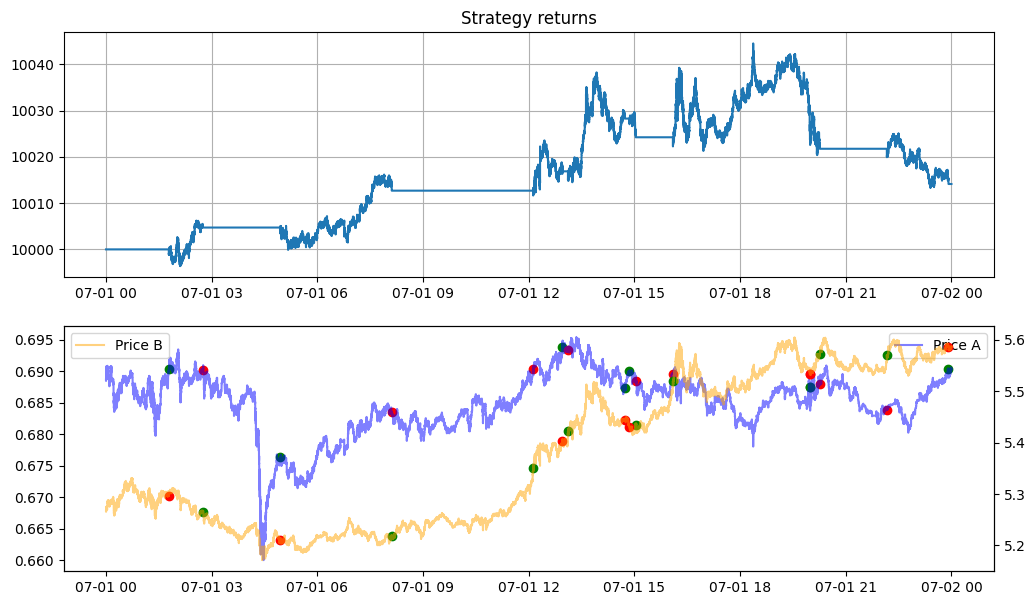

In [55]:
fig, axs = plt.subplots(2, figsize=(12, 7), facecolor='white')

ax1 = axs[0]
ax1.plot(ind.quote + ind.usd_a + ind.usd_b, label='Quote Balance')

ax2 = axs[1]
ax22 = ax2.twinx()
ax2.plot(ind.price_a, label='Price A', color='blue', alpha=0.5)
ax2.scatter(trades_a[trades_a.side == 1].index, trades_a[trades_a.side == 1].price, color='green')
ax2.scatter(trades_a[trades_a.side == 0].index, trades_a[trades_a.side == 0].price, color='red')


ax22.plot(ind.price_b, label='Price B', color='orange', alpha=0.5)
ax22.scatter(trades_b[trades_b.side == 1].index, trades_b[trades_b.side == 1].price, color='green')
ax22.scatter(trades_b[trades_b.side == 0].index, trades_b[trades_b.side == 0].price, color='red')
ax2.legend()
ax22.legend()

ax1.set_title(f"Strategy returns")
ax1.grid()